In [1]:
## COMBINE P-VALUES ##

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

import sys, os
import re
from collections import defaultdict
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
from matplotlib.patches import Rectangle, Polygon
import seaborn as sns
sns.set_style('white')

import geneinfo as gi
gi.email('ariadna.saez@alum.esci.upf.edu')


%env http_proxy=http://proxy-default:3128

def fisher_method_log10(pvalues):
    df = 2 * len(pvalues)
    return -np.log10(1 - chi2.cdf(-2 * sum(map(np.log, pvalues)), df))

def fisher_method(pvalues):
    df = 2* len(pvalues)
    return 1-chi2.cdf(-2*sum(map(np.log, pvalues)), df)


env: http_proxy=http://proxy-default:3128


Merged file for LWK:
              pos  when_mutation_has_freq2         p  relate_p
1         2781865                -1.805110  0.559215  0.015664
2         2781927                -0.581409  0.825397  0.262175
3         2782572                -0.057022  0.497412  0.876956
4         2784657                -1.002310  0.806016  0.099470
5         2784758                -0.515567  0.162963  0.305094
...           ...                      ...       ...       ...
316226  155686314                -0.272410  0.419090  0.534060
316227  155687184                -0.126810  0.858721  0.746775
316232  155695384                -0.156513  0.942252  0.697408
316235  155696715                -0.340360  0.350237  0.456709
316239  155699751                -1.394590  0.960856  0.040310

[164071 rows x 4 columns]


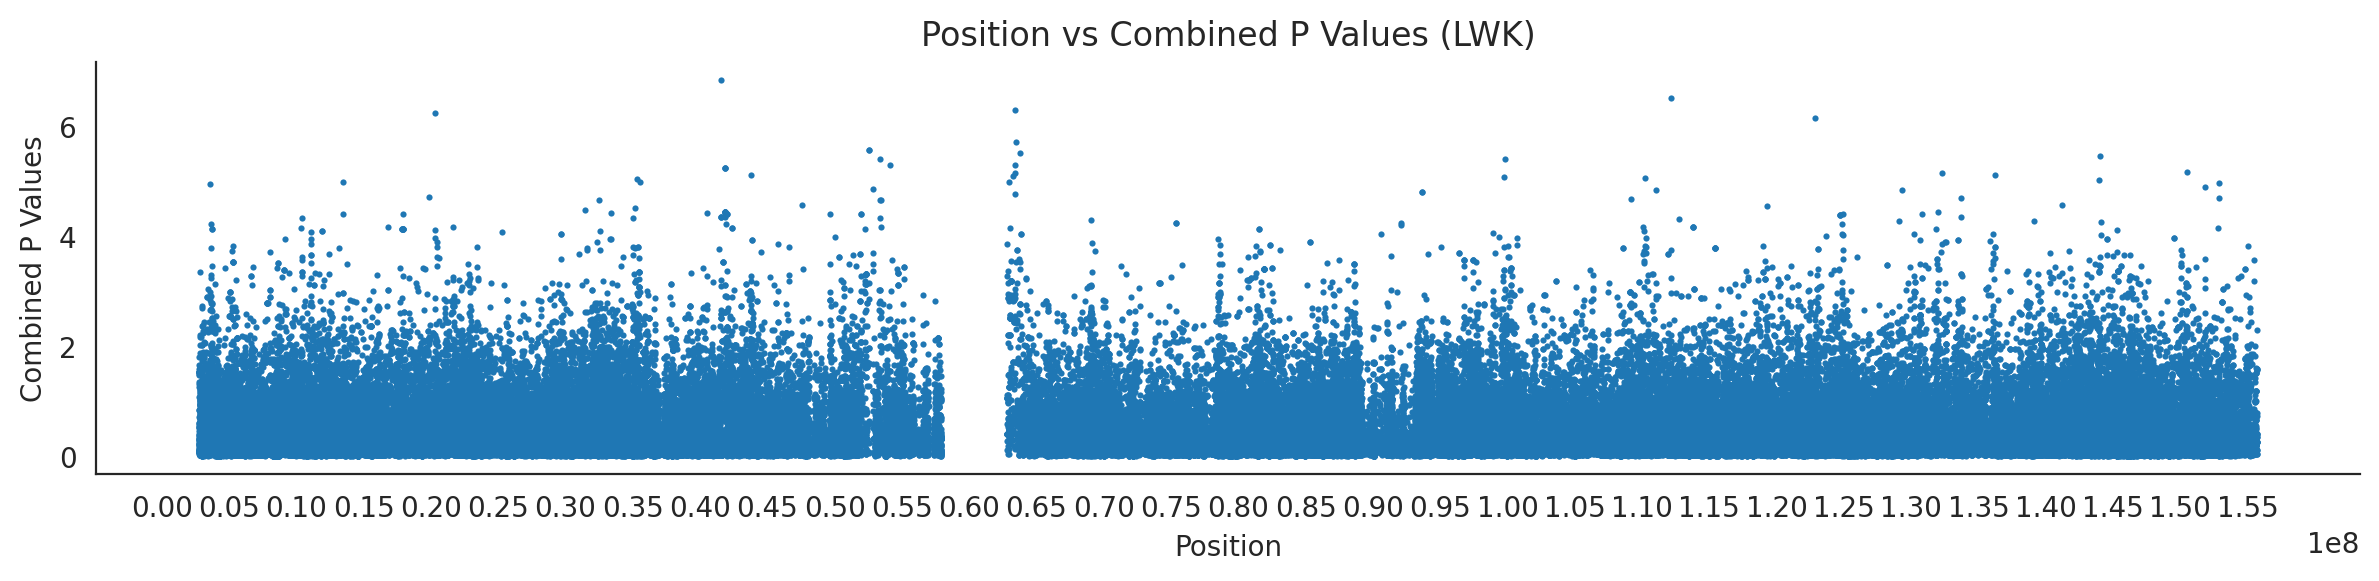

Merged file for ESN:
              pos  when_mutation_has_freq2         p  relate_p
0         2781514                -0.757029  0.724885  0.174973
1         2781584                -0.658046  0.903371  0.219763
2         2781635                -0.203300  0.282618  0.626181
4         2781865                -0.580090  0.691273  0.262972
5         2781927                -0.879552  0.715159  0.131962
...           ...                      ...       ...       ...
342323  155688581                -0.484202  0.926298  0.327943
342328  155695384                -0.129718  0.897104  0.741792
342331  155696715                -0.381819  0.316431  0.415127
342332  155697006                -0.973781  1.000000  0.106223
342336  155699751                -0.867858  0.854032  0.135563

[183143 rows x 4 columns]


In [ ]:
# List of populations and their file paths
populations = {
    # africans
    'LWK': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/LWK/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_LWK_runstats.h5"
    },
    'ESN': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/ESN/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_ESN_runstats.h5"
    },
    'GWD': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/GWD/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GWD_runstats.h5"
    },
    'MSL': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/MSL/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_MSL_runstats.h5"
    },
    'YRI': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/YRI/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_YRI_runstats.h5"
    }
}

for population, file_paths in populations.items():
    # Read files into DataFrames
    file1 = pd.read_csv(file_paths['relate'], sep=' ')
    file2 = pd.read_hdf(file_paths['kasper'])

    # Convert 'pos' column to integers in the second DataFrame (it had decimals - position.0)
    file2['pos'] = file2['pos'].astype(int)

    # Merge the two DataFrames on the 'pos' column
    merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')
    
    merged_df = merged_df.loc[(merged_df.p < 1)]
    
    # Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
    #merged_df['p'] = -np.log10(merged_df['p'])

    # Change negative values to positive (relate file contains negative values: flip for plotting)
   # merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()

    merged_df['relate_p'] = 10**merged_df.when_mutation_has_freq2
    
    merged_df = merged_df.loc[(merged_df.p < 1)]
    
    print(f"Merged file for {population}:")
    print(merged_df)
    
    combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

    # Convert data to DataFrame
    df = pd.DataFrame(merged_df)

    # Combine p-values
    combined_p_values = df[['relate_p', 'p']].apply(fisher_method, axis=1)
    
    combined_p_values = -np.log10(combined_p_values)

    # Create a new DataFrame with pos and combined p-values
    new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})
    
    # Specify the file path including the directory and population name
    file_path = os.path.join("/home/ari/ari-intern/people/ari/ariadna-intern/results", f"combined_{population}.csv")
    
    # Save the DataFrame with the population name in the filename
    new_df.to_csv(file_path, index=False)

    # Plotting
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
    plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
    plt.xlabel('Position')
    plt.ylabel('Combined P Values')
    plt.title(f'Position vs Combined P Values ({population})')
    plt.tight_layout()
    sns.despine()
    plt.show()


Merged file for GBR:
              pos  when_mutation_has_freq2         p  relate_p
0         2781604                -0.140835  0.796678  0.723044
1         2781635                -0.159586  0.715426  0.692491
2         2781927                -1.710600  0.906692  0.019472
3         2781986                -1.710600  0.906692  0.019472
4         2782116                -0.372146  0.755806  0.424477
...           ...                      ...       ...       ...
151649  155688581                -1.602200  0.565608  0.024992
151650  155693713                -0.444443  0.209805  0.359383
151651  155695384                -0.365995  0.680090  0.430532
151652  155697920                -2.492710  0.723938  0.003216
151653  155699751                -0.404917  0.616844  0.393625

[98904 rows x 4 columns]


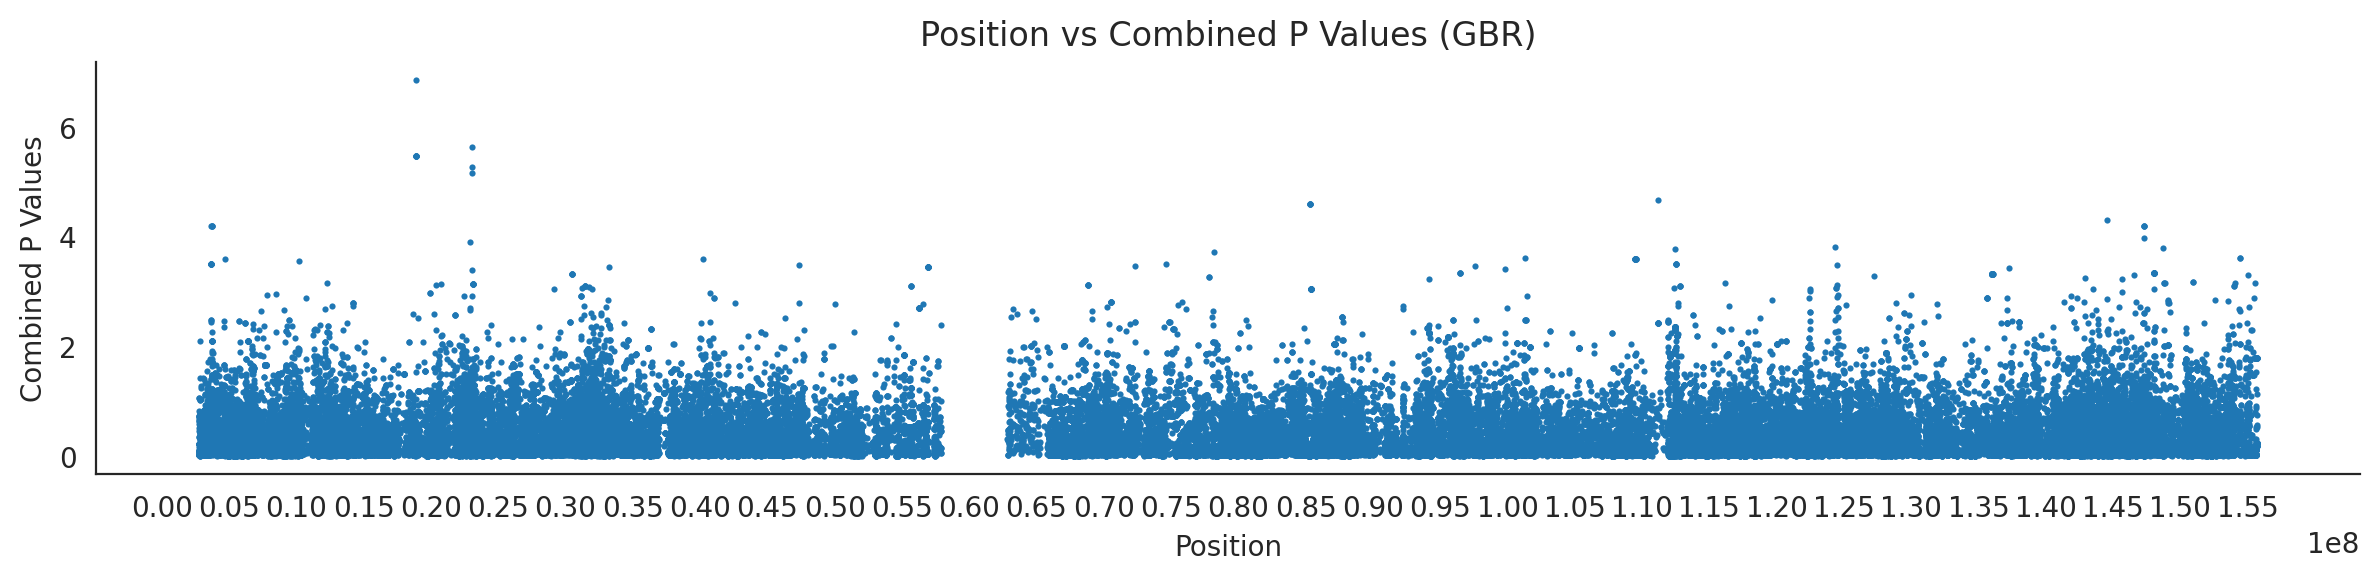

Merged file for FIN:
              pos  when_mutation_has_freq2         p  relate_p
0         2781604                -0.044371  0.484337  0.902878
2         2781927                -1.309770  0.661468  0.049004
3         2781986                -1.309770  0.661468  0.049004
4         2782116                -0.044371  0.484337  0.902878
5         2782161                -0.036395  0.709697  0.919614
...           ...                      ...       ...       ...
159917  155688581                -0.136697  0.294709  0.729967
159920  155695384                -0.478270  0.409407  0.332453
159921  155696325                -0.708800  0.166317  0.195524
159922  155697920                -3.409930  0.718972  0.000389
159924  155699751                -0.036395  0.554544  0.919614

[100299 rows x 4 columns]


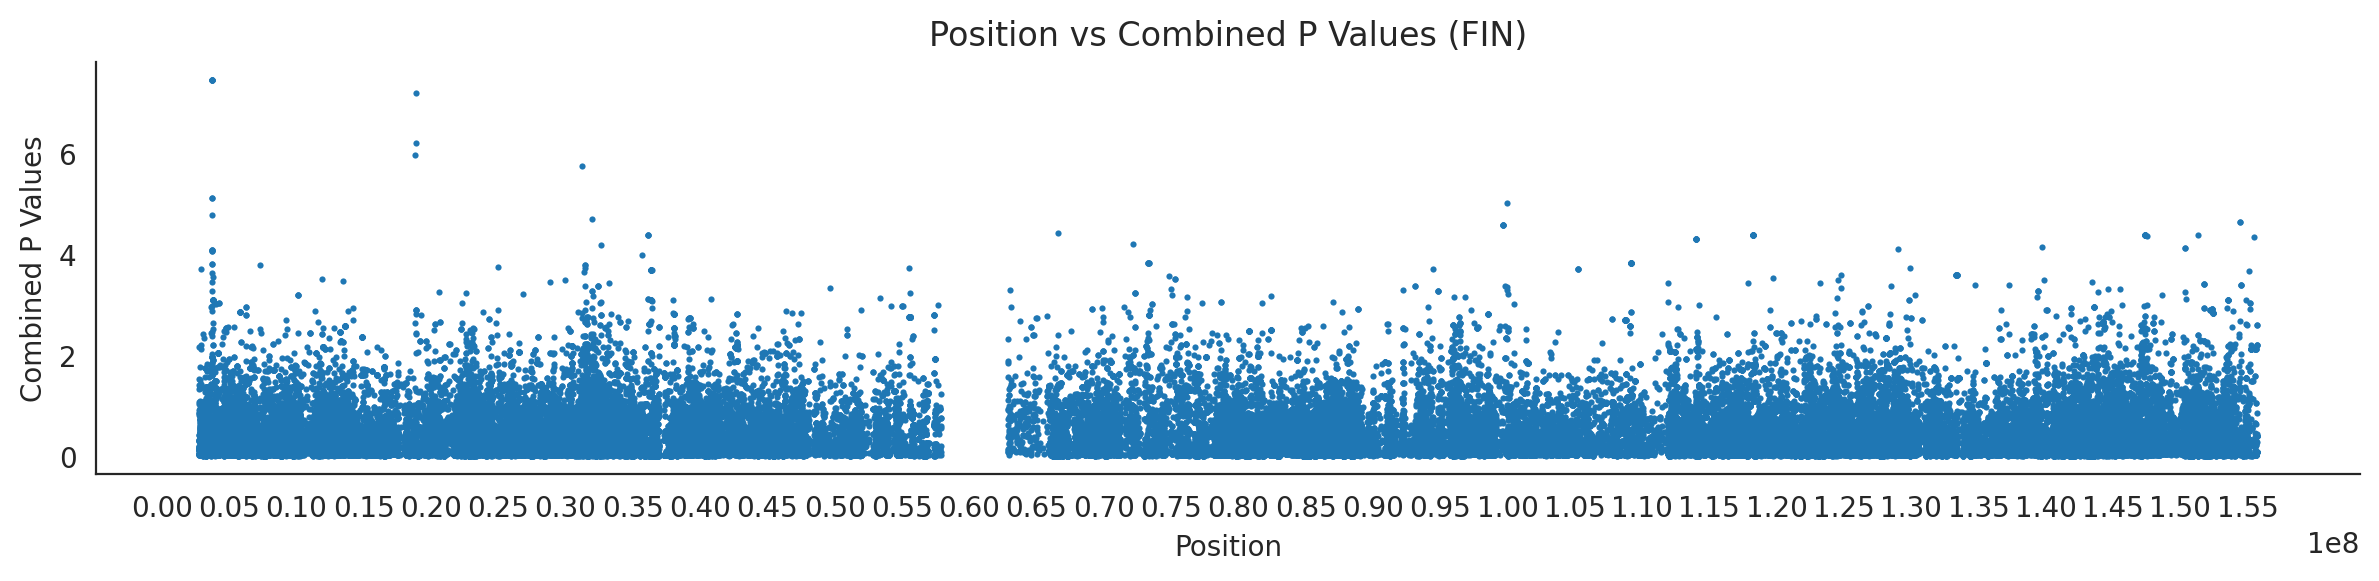

Merged file for IBS:
              pos  when_mutation_has_freq2         p  relate_p
0         2781514                -0.430028  0.658414  0.371511
1         2781604                -0.487534  0.523774  0.325436
2         2781635                -0.408764  0.890985  0.390154
3         2781927                -1.165120  0.718518  0.068372
4         2781986                -1.165120  0.718518  0.068372
...           ...                      ...       ...       ...
181309  155688581                -0.304668  0.818028  0.495829
181310  155693713                -0.345917  0.290844  0.450903
181311  155695384                -0.481591  0.426761  0.329920
181313  155697920                -3.375790  0.826080  0.000421
181315  155699751                -0.067853  0.374625  0.855357

[109375 rows x 4 columns]


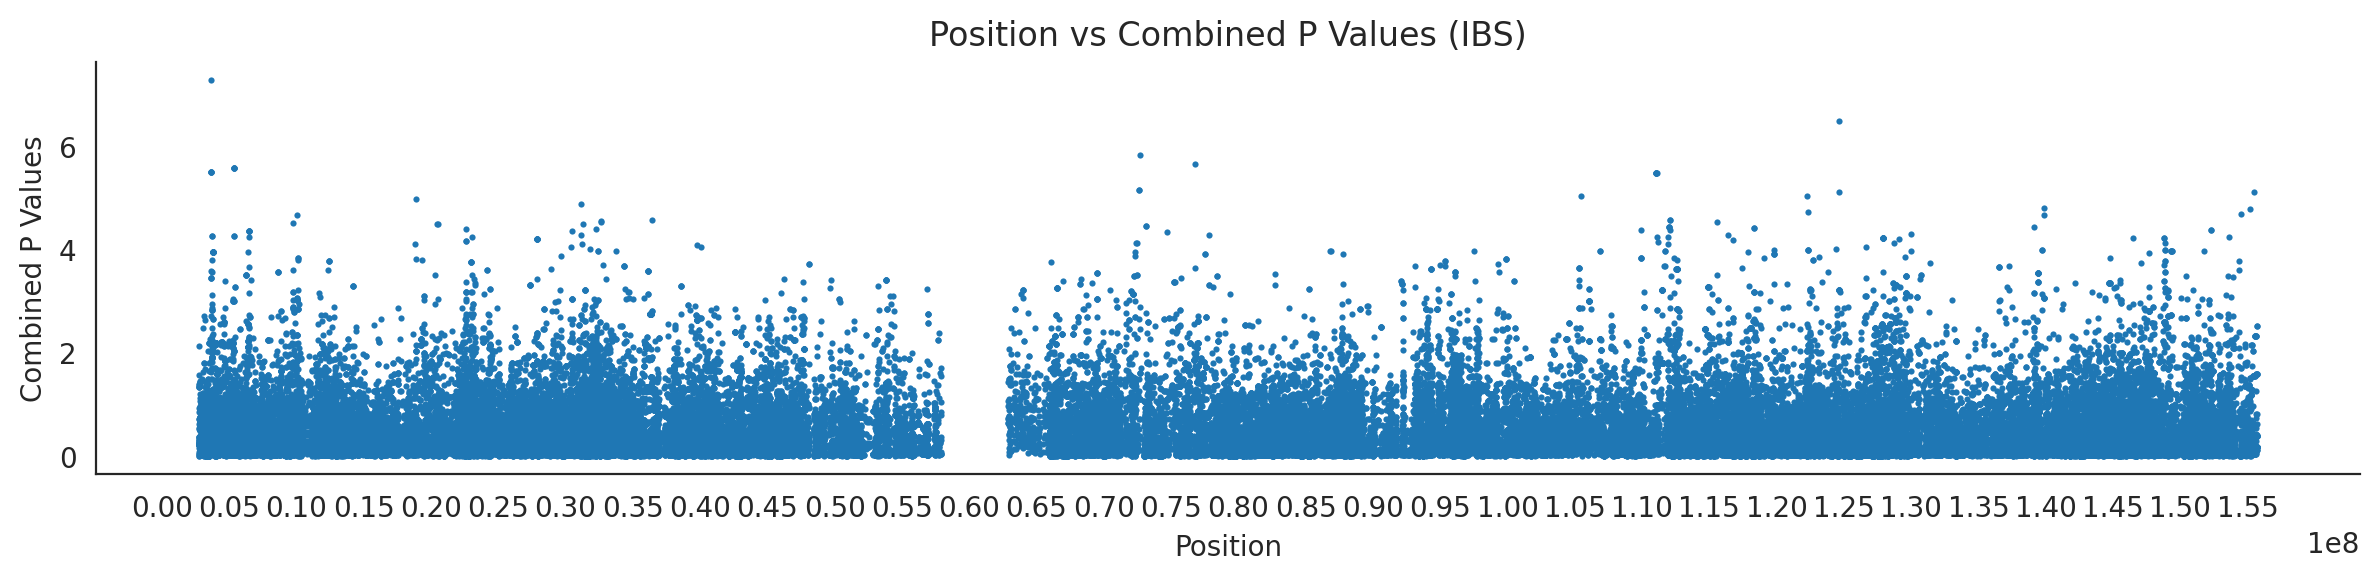

Merged file for TSI:
              pos  when_mutation_has_freq2         p  relate_p
0         2781604                -0.288686  1.000000  0.514415
1         2781635                -0.163362  0.445120  0.686496
2         2781927                -1.293830  0.702406  0.050836
3         2781986                -1.293830  0.702406  0.050836
5         2782161                -0.300171  0.251178  0.500990
...           ...                      ...       ...       ...
158587  155686314                -0.419196  0.947955  0.380894
158588  155687184                -0.419196  0.947955  0.380894
158591  155695384                -0.419196  0.947955  0.380894
158593  155697920                -2.507860  0.627597  0.003106
158595  155699751                -0.090797  0.949137  0.811339

[100369 rows x 4 columns]


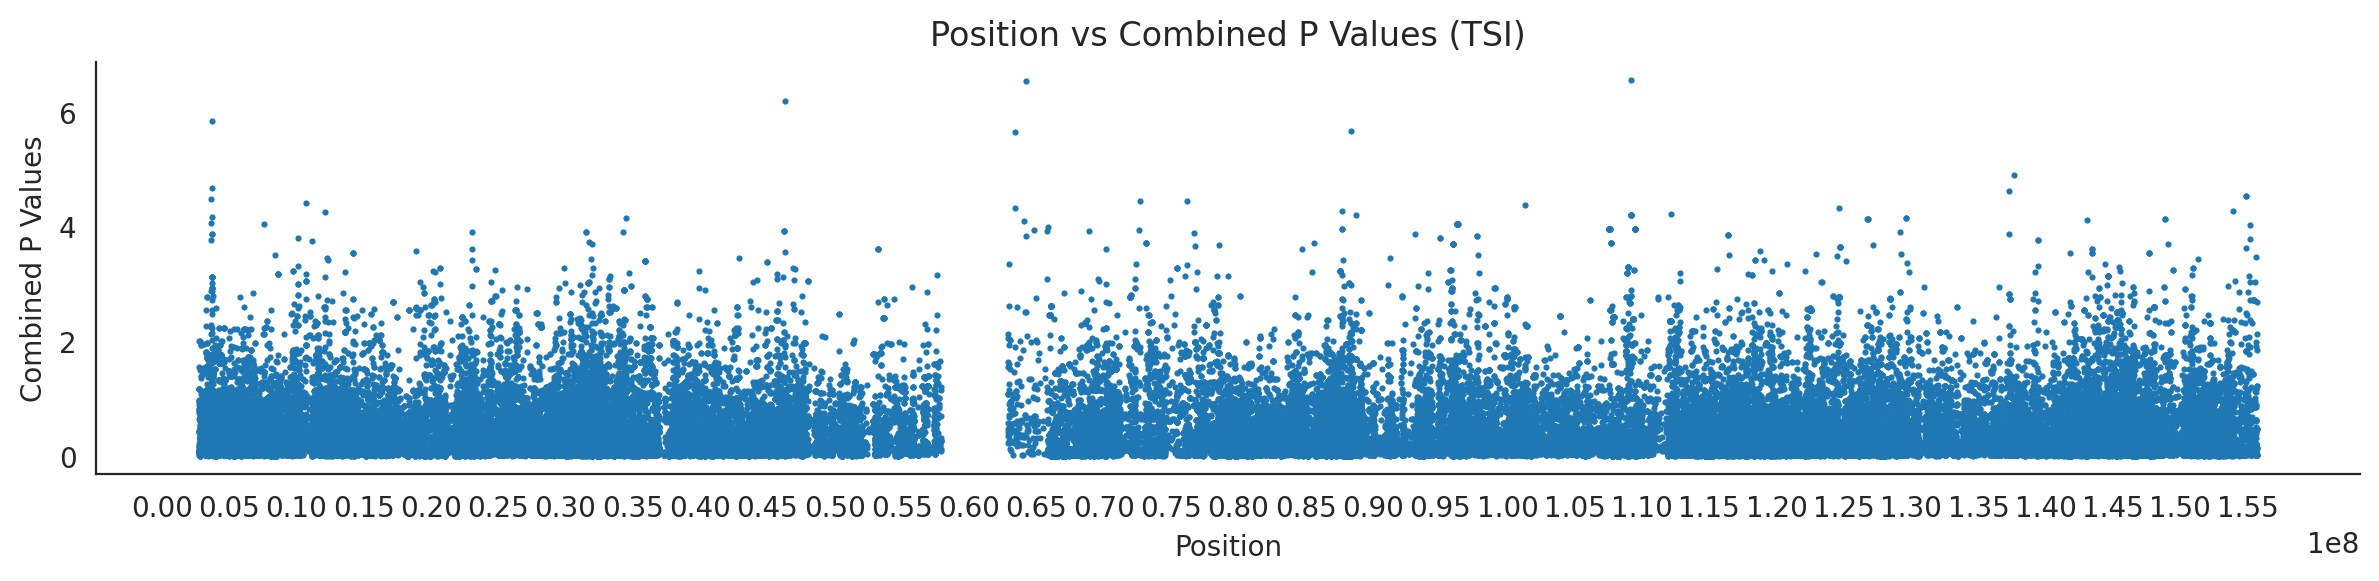

Merged file for PUR:
              pos  when_mutation_has_freq2         p  relate_p
0         2781514                -0.337251  0.801855  0.459991
2         2781604                -0.385397  0.925864  0.411721
3         2781635                -0.346893  0.806642  0.449891
4         2781927                -1.868690  0.970570  0.013530
5         2782116                -0.498154  0.424774  0.317575
...           ...                      ...       ...       ...
255739  155688581                -0.713522  0.291062  0.193410
255741  155694896                -1.573550  0.276854  0.026696
255742  155695384                -0.734242  0.652714  0.184399
255745  155697920                -5.706710  0.417134  0.000002
255747  155699751                -0.489125  0.663368  0.324246

[130954 rows x 4 columns]


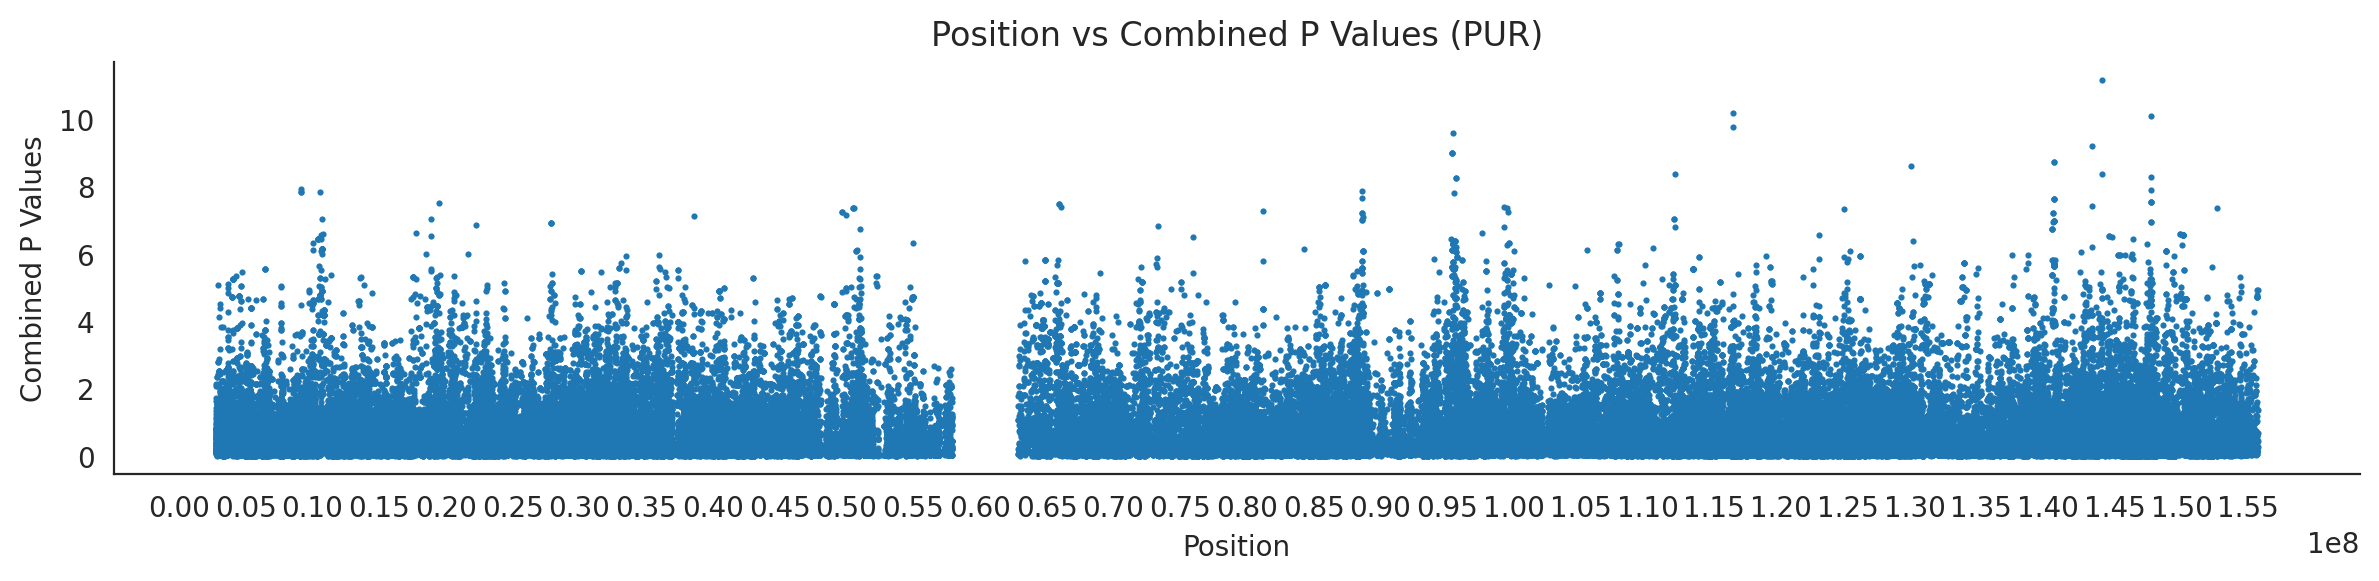

In [5]:
populations = {
    # europeans
    'GBR': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/GBR/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GBR_runstats.h5"
    },
    'FIN': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/FIN/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_FIN_runstats.h5"
    },
    'IBS': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/IBS/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_IBS_runstats.h5"
    },
    'TSI': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/TSI/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_TSI_runstats.h5"
    },
    'PUR': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/PUR/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_PUR_runstats.h5"
    }
}

for population, file_paths in populations.items():
    # Read files into DataFrames
    file1 = pd.read_csv(file_paths['relate'], sep=' ')
    file2 = pd.read_hdf(file_paths['kasper'])

    # Convert 'pos' column to integers in the second DataFrame (it had decimals - position.0)
    file2['pos'] = file2['pos'].astype(int)

    # Merge the two DataFrames on the 'pos' column
    merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')
    
    merged_df = merged_df.loc[(merged_df.p < 1)]
    
    # Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
    #merged_df['p'] = -np.log10(merged_df['p'])

    # Change negative values to positive (relate file contains negative values: flip for plotting)
   # merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()

    merged_df['relate_p'] = 10**merged_df.when_mutation_has_freq2
    
    merged_df = merged_df.loc[(merged_df.p < 1)]
    
    print(f"Merged file for {population}:")
    print(merged_df)
    
    combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

    # Convert data to DataFrame
    df = pd.DataFrame(merged_df)

    # Combine p-values
    combined_p_values = df[['relate_p', 'p']].apply(fisher_method, axis=1)
    
    combined_p_values = -np.log10(combined_p_values)

    # Create a new DataFrame with pos and combined p-values
    new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})
    
    # Specify the file path including the directory and population name
    file_path = os.path.join("/home/ari/ari-intern/people/ari/ariadna-intern/results", f"combined_{population}.csv")
    
    # Save the DataFrame with the population name in the filename
    new_df.to_csv(file_path, index=False)

    # Plotting
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
    plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
    plt.xlabel('Position')
    plt.ylabel('Combined P Values')
    plt.title(f'Position vs Combined P Values ({population})')
    plt.tight_layout()
    sns.despine()
    plt.show()

Merged file for CDX:
              pos  when_mutation_has_freq2         p  relate_p
0         2781635                -0.486720  0.696915  0.326047
1         2781927                -0.553480  0.991296  0.279589
2         2781986                -0.553480  0.991296  0.279589
3         2782161                -1.367980  0.636076  0.042857
5         2782572                -1.695870  0.947793  0.020143
...           ...                      ...       ...       ...
138117  155694896                -2.205470  0.729772  0.006231
138118  155695384                -0.219482  0.638593  0.603279
138119  155695745                -0.206570  0.117527  0.621484
138120  155697920                -0.219482  0.638593  0.603279
138121  155699751                -0.152693  0.573778  0.703569

[88388 rows x 4 columns]


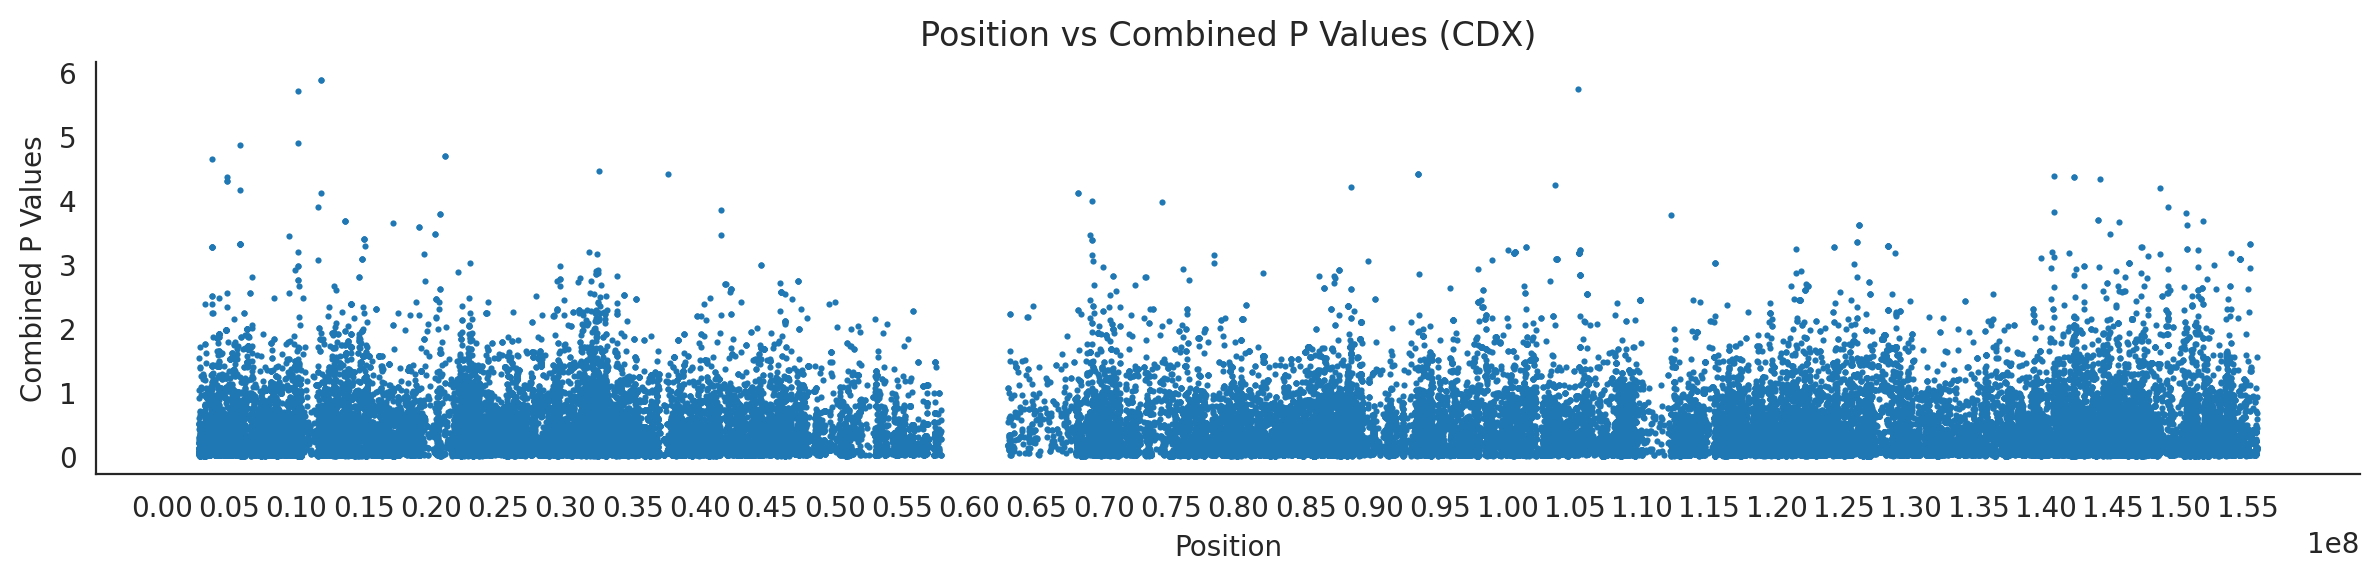

Merged file for CHB:
              pos  when_mutation_has_freq2         p  relate_p
0         2781927                -0.707989  0.542114  0.195889
1         2781986                -0.707989  0.542114  0.195889
2         2782161                -0.803470  0.783276  0.157228
3         2782572                -2.224800  0.612184  0.005959
4         2784758                -0.067107  0.715347  0.856827
...           ...                      ...       ...       ...
138174  155686314                -0.395042  0.746994  0.402678
138175  155687184                -0.395042  0.746994  0.402678
138179  155695384                -0.395042  0.746994  0.402678
138180  155697920                -0.395042  0.746994  0.402678
138181  155699751                -0.102783  0.792484  0.789254

[89775 rows x 4 columns]


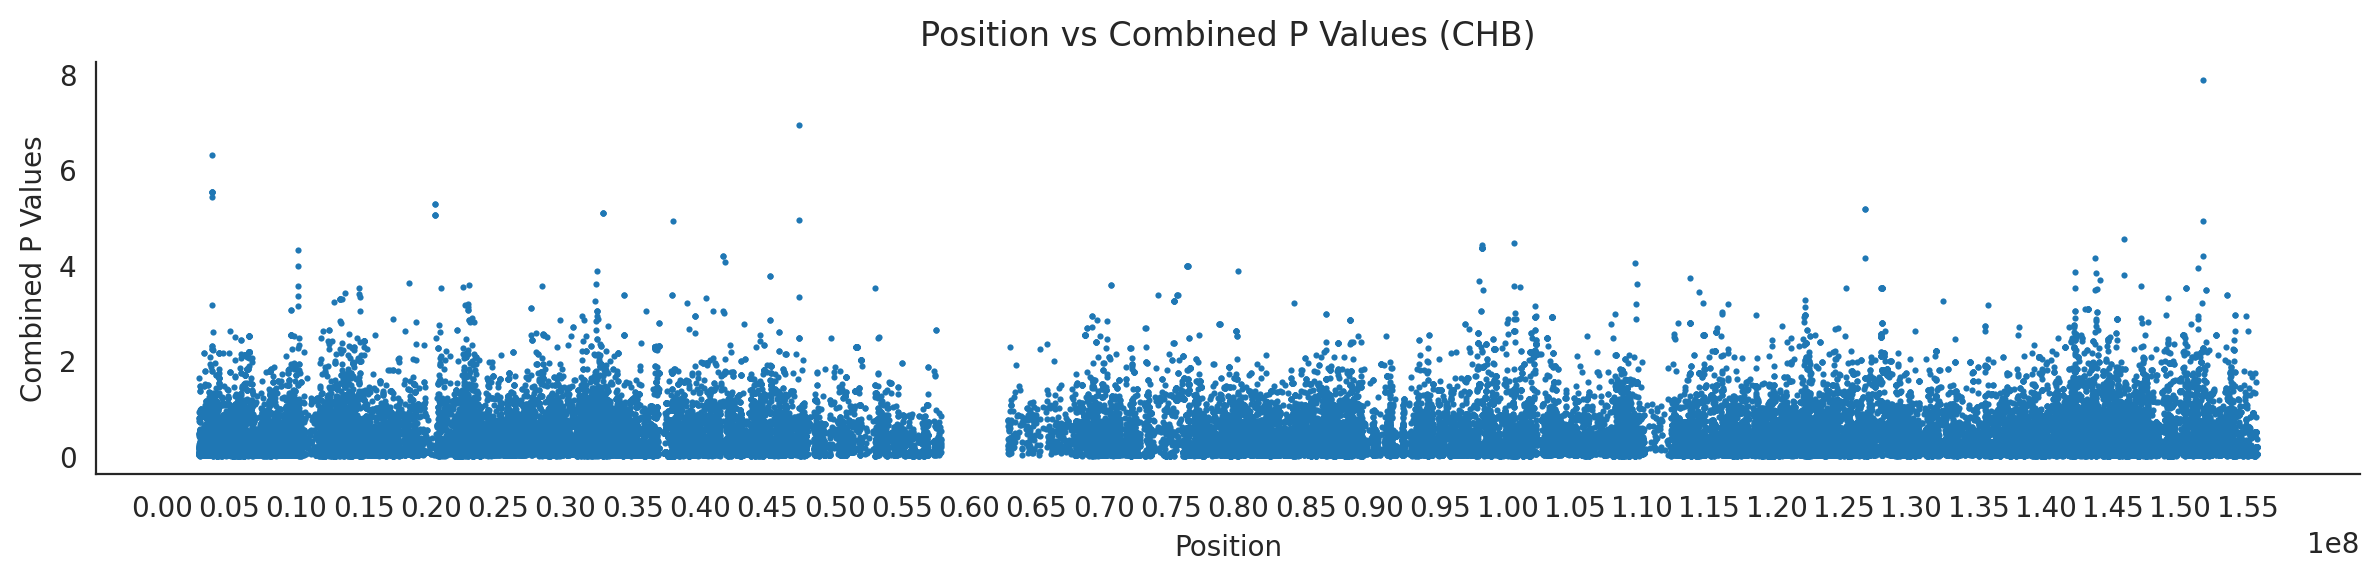

Merged file for CHS:
              pos  when_mutation_has_freq2         p  relate_p
0         2781635                -0.926999  0.993855  0.118304
1         2781927                -0.294591  0.824751  0.507468
2         2781986                -0.294591  0.824751  0.507468
3         2782161                -1.741520  0.276912  0.018133
4         2782572                -0.533548  0.941526  0.292720
...           ...                      ...       ...       ...
156188  155686314                -1.931780  0.637411  0.011701
156189  155687184                -1.931780  0.637411  0.011701
156195  155695384                -1.931780  0.637411  0.011701
156197  155697920                -1.931780  0.637411  0.011701
156199  155699751                -0.103049  0.626163  0.788771

[96894 rows x 4 columns]


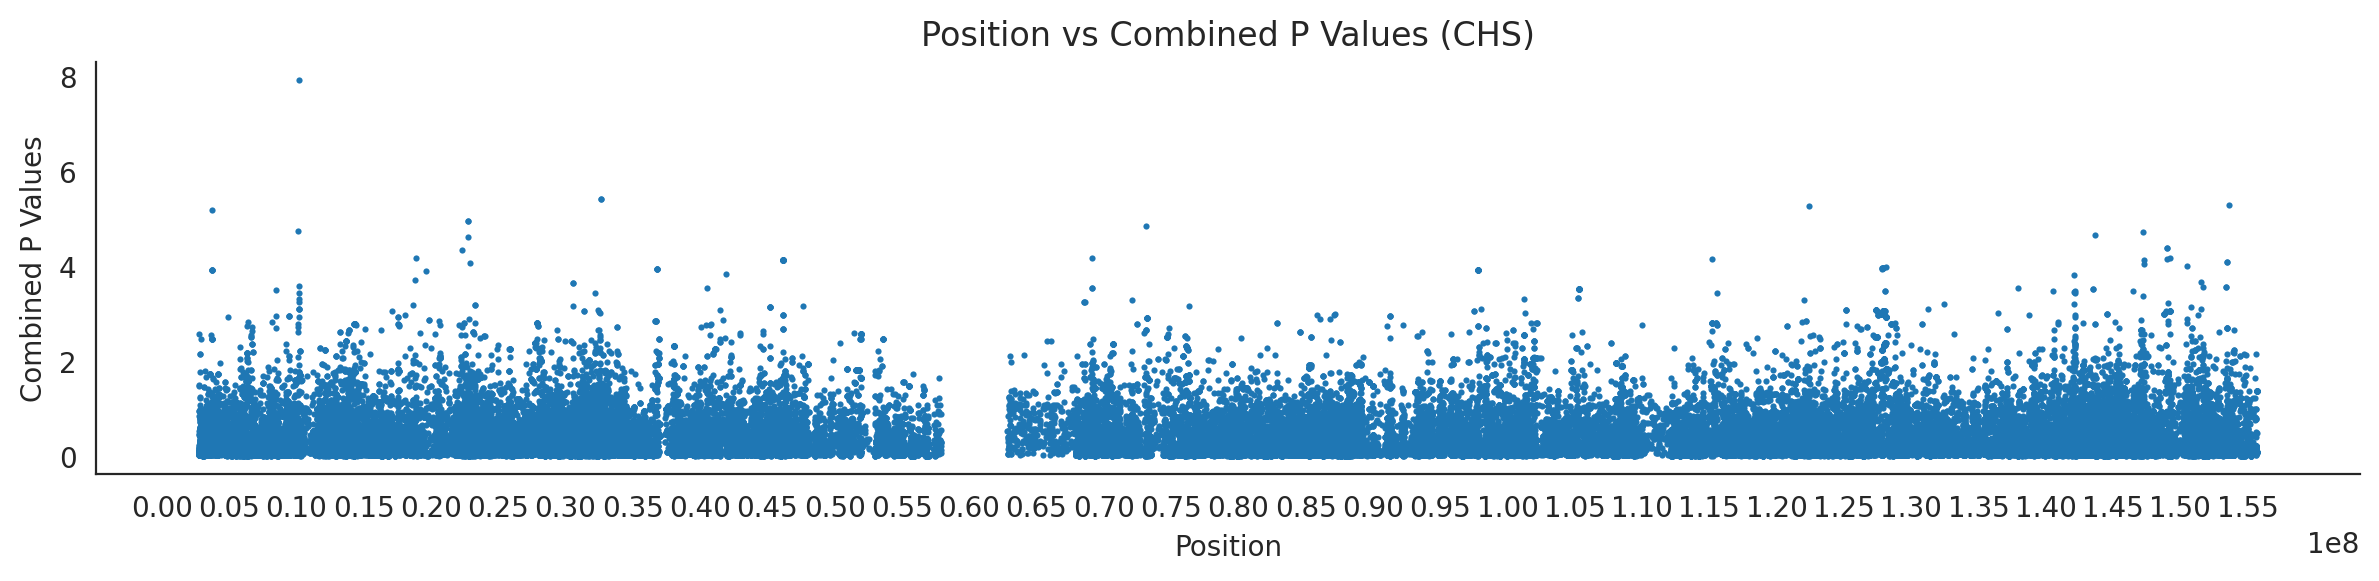

Merged file for KHV:
              pos  when_mutation_has_freq2         p  relate_p
0         2781635                -0.847264  0.862792  0.142146
1         2781927                -0.635131  0.918624  0.231670
2         2781986                -0.635131  0.918624  0.231670
3         2782161                -0.406086  0.968240  0.392567
4         2784102                -0.471176  0.992408  0.337928
...           ...                      ...       ...       ...
148478  155687184                -1.393270  0.988351  0.040432
148479  155694896                -1.165930  0.452724  0.068245
148480  155695384                -1.393270  0.988351  0.040432
148483  155697920                -1.393270  0.988351  0.040432
148484  155699751                -0.047057  0.985767  0.897310

[94609 rows x 4 columns]


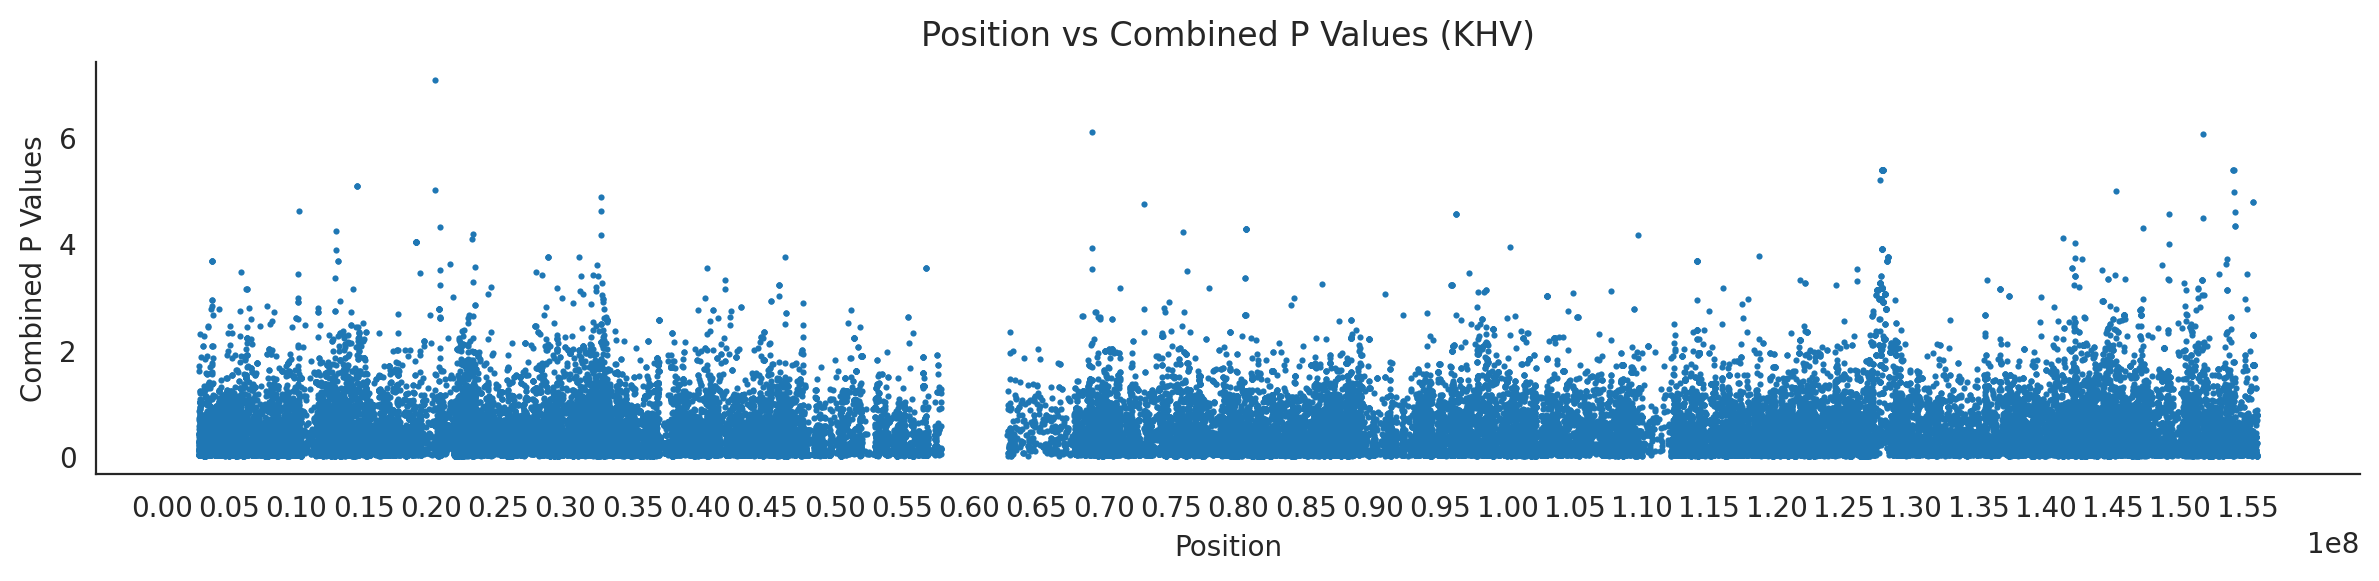

Merged file for JPT:
              pos  when_mutation_has_freq2         p  relate_p
0         2781514                -0.746704  0.915583  0.179183
1         2781986                -0.112781  0.544237  0.771292
2         2782572                -1.069260  0.718797  0.085259
3         2784758                -0.483658  0.805274  0.328354
4         2784905                -0.483658  0.805274  0.328354
...           ...                      ...       ...       ...
137491  155686314                -0.516201  0.988232  0.304648
137492  155687184                -0.516201  0.988232  0.304648
137496  155695384                -3.159730  0.989062  0.000692
137497  155697920                -3.159730  0.989062  0.000692
137498  155699751                -0.055012  0.984569  0.881025

[87889 rows x 4 columns]


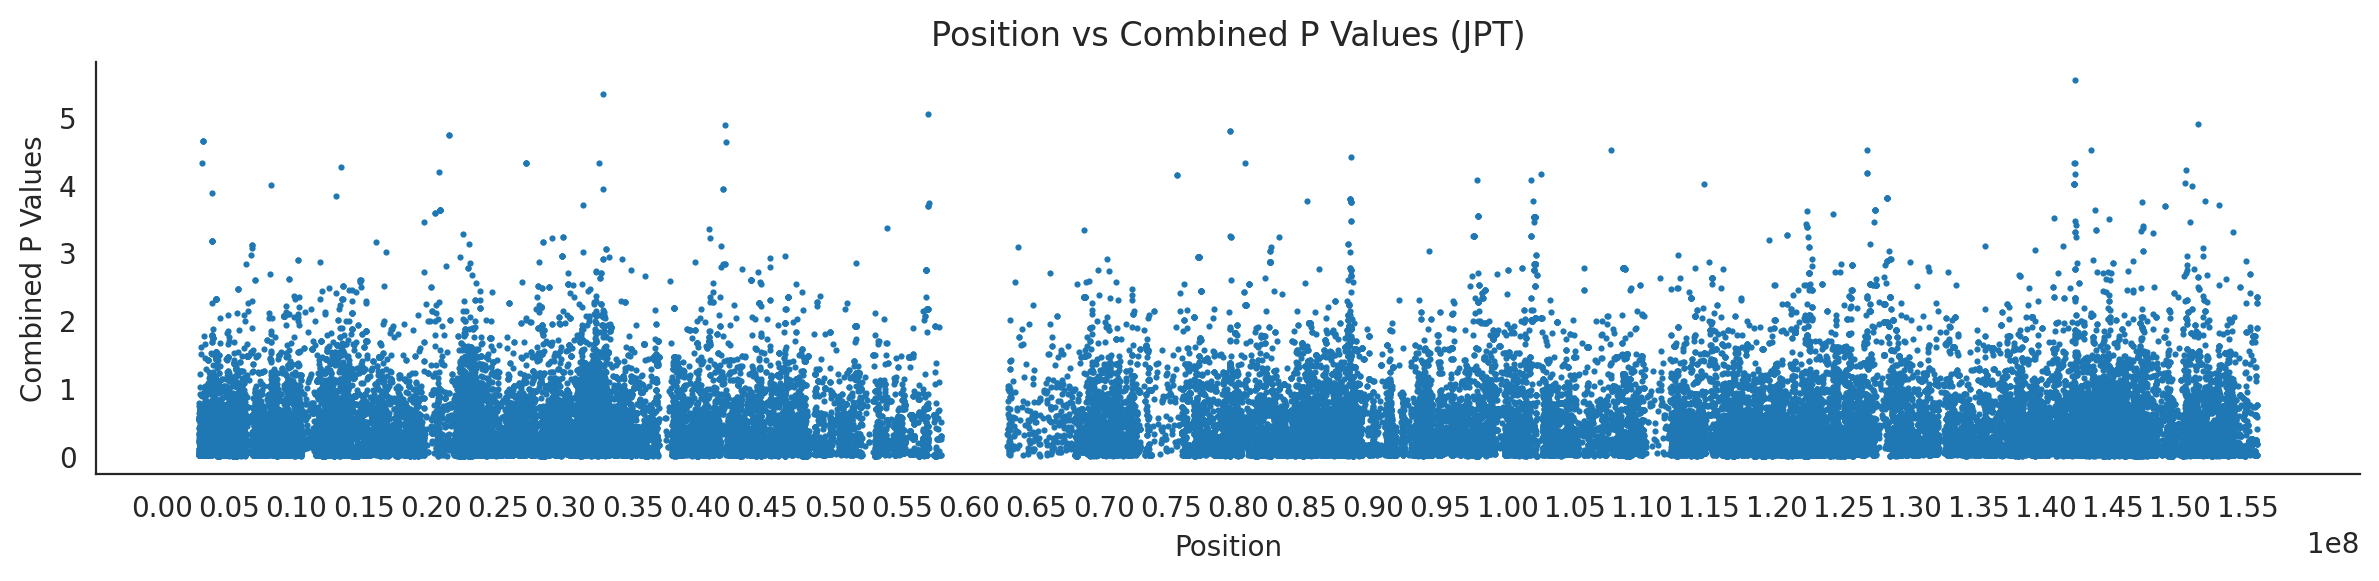

In [6]:
populations = {
    # asians
    'CDX': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/CDX/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CDX_runstats.h5"
    },
    'CHB': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHB/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHB_runstats.h5"
    },
    'CHS': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHS/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHS_runstats.h5"
    },
    'KHV': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/KHV/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_KHV_runstats.h5"
    },
    'JPT': {
        'relate': "/home/ari/ari-intern/people/ari/ariadna-intern/steps/JPT/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele",
        'kasper': "/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_JPT_runstats.h5"
    }
}


for population, file_paths in populations.items():
    # Read files into DataFrames
    file1 = pd.read_csv(file_paths['relate'], sep=' ')
    file2 = pd.read_hdf(file_paths['kasper'])

    # Convert 'pos' column to integers in the second DataFrame (it had decimals - position.0)
    file2['pos'] = file2['pos'].astype(int)

    # Merge the two DataFrames on the 'pos' column
    merged_df = pd.merge(file1[['pos', 'when_mutation_has_freq2']], file2[['pos', 'p']], on='pos', how='inner')
    
    merged_df = merged_df.loc[(merged_df.p < 1)]
    
    # Apply -np.log10() function to the 'p' column (K p-value is not under logarithm)
    #merged_df['p'] = -np.log10(merged_df['p'])

    # Change negative values to positive (relate file contains negative values: flip for plotting)
   # merged_df[['when_mutation_has_freq2', 'p']] = merged_df[['when_mutation_has_freq2', 'p']].abs()

    merged_df['relate_p'] = 10**merged_df.when_mutation_has_freq2
    
    merged_df = merged_df.loc[(merged_df.p < 1)]
    
    print(f"Merged file for {population}:")
    print(merged_df)
    
    combined_values = merged_df[['when_mutation_has_freq2', 'p']].values.tolist() # list of pairs

    # Convert data to DataFrame
    df = pd.DataFrame(merged_df)

    # Combine p-values
    combined_p_values = df[['relate_p', 'p']].apply(fisher_method, axis=1)
    
    combined_p_values = -np.log10(combined_p_values)

    # Create a new DataFrame with pos and combined p-values
    new_df = pd.DataFrame({'pos': df['pos'], 'combined_p_values': combined_p_values})
    
    # Specify the file path including the directory and population name
    file_path = os.path.join("/home/ari/ari-intern/people/ari/ariadna-intern/results", f"combined_{population}.csv")
    
    # Save the DataFrame with the population name in the filename
    new_df.to_csv(file_path, index=False)

    # Plotting
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data=new_df, x='pos', y='combined_p_values', linewidth=0, s=5)
    plt.xticks(np.arange(0, new_df['pos'].max()+1, 5000000))
    plt.xlabel('Position')
    plt.ylabel('Combined P Values')
    plt.title(f'Position vs Combined P Values ({population})')
    plt.tight_layout()
    sns.despine()
    plt.show()

In [6]:
LWK = pd.read_csv("/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_LWK.csv")
ESN = pd.read_csv("/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_ESN.csv")
GWD = pd.read_csv("/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_GWD.csv")
MSL = pd.read_csv("/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_MSL.csv")
YRI = pd.read_csv("/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_YRI.csv")

In [7]:
# Filter the DataFrame for rows where combined_p_values is higher than 6
subset = LWK[LWK['combined_p_values'] > 6]






In [8]:
subset.to_csv("/home/ari/ari-intern/people/ari/ariadna-intern/results/subset.csv", index=False)

In [9]:
import pandas as pd

# List of population names and their corresponding file paths
populations = {
    'LWK': "/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_LWK.csv",
    'ESN': "/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_ESN.csv",
    'GWD': "/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_GWD.csv",
    'MSL': "/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_MSL.csv",
    'YRI': "/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_YRI.csv"
}

# Initialize an empty DataFrame to store the combined subset
combined_subset = pd.DataFrame()

# Iterate over each population and its corresponding file path
for population, file_path in populations.items():
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Filter rows with combined_p_values higher than 6
    subset = df[df['combined_p_values'] > 6].copy()
    
    # Add a 'population' column with the current population name
    subset['population'] = population
    
    # Concatenate the subset with the combined_subset DataFrame
    combined_subset = pd.concat([combined_subset, subset], ignore_index=True)

# Save the combined subset to a CSV file
combined_subset.to_csv("/home/ari/ari-intern/people/ari/ariadna-intern/results/combined_subset.csv", index=False)

# Display the first few rows of the combined subset
print(combined_subset.head())


       pos  combined_p_values population
0  2781642                inf        LWK
1  2783658                inf        LWK
2  2786016                inf        LWK
3  2790078                inf        LWK
4  2790108                inf        LWK
